In [1]:
import sys

sys.path.append('../')
from src import dataset
import numpy as np
from src.model import Unet
import torch
import torch.nn.functional as F

In [2]:
T = 200

In [3]:
alphas = 1. - torch.linspace(0.001, 0.2, T)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - sqrt_alphas_cumprod ** 2)

In [4]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [5]:
# forward diffusion
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

In [6]:
def p_losses(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_0=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)
    loss = F.mse_loss(noise, predicted_noise)
    return loss

In [7]:
from torchvision.transforms import Compose

In [8]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("mnist")
image_size = 28
channels = 1
batch_size = 128

In [9]:
print(dataset['train'][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7FABE7988F10>, 'label': 5}


47037
25539
40279
20948
39108
57715
41449
2056
34910
31099


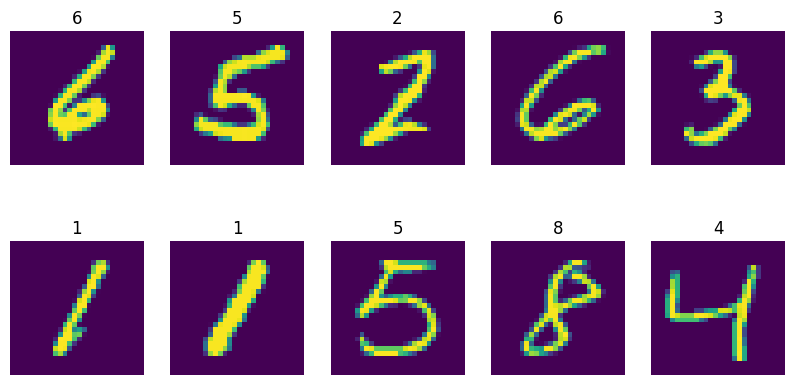

In [10]:
# Plot 10 images
import matplotlib.pyplot as plt
labels_names = dataset['train'].features['label'].names
random_indexes = np.random.randint(0, len(dataset['train']), 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    print(random_indexes[i])
    ax.imshow(dataset['train'][int(random_indexes[i])]['image'])
    ax.set_title(labels_names[dataset['train'][int(random_indexes[i])]['label']])
    ax.axis('off')
plt.imshow(dataset['train'][2]['image'])
plt.title(labels_names[dataset['train'][2]['label']])
plt.show()

In [11]:
from torch.optim import Adam, AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4)
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)

In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [13]:
from pathlib import Path

In [14]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [15]:
# define beta schedule
betas = linear_beta_schedule(timesteps=T)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [16]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [17]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)

In [18]:
from torchvision.utils import save_image
from tqdm import tqdm

In [19]:

epochs = 5
save_and_sample_every = 1000    
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    for step, batch in enumerate(tqdm(dataloader)):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, T, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t)

      if step % 100 == -1:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Epoch 1
-------------------------------


100%|██████████| 469/469 [13:53<00:00,  1.78s/it]


Epoch 2
-------------------------------


100%|██████████| 469/469 [13:55<00:00,  1.78s/it]


Epoch 3
-------------------------------


 34%|███▎      | 158/469 [04:43<09:18,  1.79s/it]


KeyboardInterrupt: 

In [ ]:
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# show a random one
random_index = 5
plt.imshow(samples[0][random_index].reshape(image_size, image_size, channels), cmap="gray")
plt.show()
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

In [ ]:
import matplotlib.animation as animation

random_index = 53

fig = plt.figure()
ims = []
for i in range(T):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('mnist_from_nothing.gif')
plt.show()

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'mnist.ckpt')


In [20]:
# Load the model checkpoint
torch.load('mnist.ckpt', map_location=torch.device('cpu'))

OrderedDict([('init_conv.weight',
              tensor([[[[ 6.4317e-02, -2.1978e-02, -1.1961e-01,  9.7134e-02, -1.2630e-01,
                          8.7812e-02, -1.4944e-02],
                        [-8.1095e-02,  1.0546e-01, -1.0863e-01,  4.3595e-02,  4.3772e-02,
                          4.9139e-02,  6.2668e-02],
                        [ 4.5102e-02, -1.1889e-01, -5.9040e-02,  4.1405e-02, -1.1309e-01,
                          5.5541e-02, -8.1937e-02],
                        [-1.0114e-01,  7.6794e-02, -2.6439e-02, -1.8493e-01, -7.1314e-02,
                          4.8583e-02, -1.2902e-01],
                        [ 5.8231e-02,  1.0861e-01,  1.8349e-02, -6.1375e-02, -4.4937e-02,
                         -6.6029e-03,  3.5179e-02],
                        [-3.0492e-02, -3.5853e-02,  4.2937e-02, -1.4627e-01, -1.7548e-02,
                         -1.1899e-01, -4.3490e-02],
                        [-6.6750e-02, -3.2771e-02, -9.7838e-02,  2.1458e-02, -1.7943e-02,
                        

In [21]:
@torch.no_grad()
def p_sample_loop_inf(model, data):
    device = next(model.parameters()).device
    b = data.shape[0]
    img = data
    imgs = []
    
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

In [22]:
import matplotlib.animation as animation

def test_and_gif(index):
    noised_image = dataset['train'][index]['image']
    label = dataset['train'][index]['label']
    print('Image label:', labels_names[dataset['train'][index]['label']])
    plt.imshow(noised_image)
    plt.title('Original image')
    plt.show()
    noised_image = transform(noised_image)
    noised_image = q_sample(noised_image, torch.full((1,), T-1, device=device, dtype=torch.long))
    plt.imshow(noised_image.reshape(image_size, image_size, channels), cmap="gray")
    plt.title('Noised image')
    plt.show()
    
    denoised = p_sample_loop_inf(model, data=noised_image)
    plt.imshow(denoised[-1].reshape(image_size, image_size, channels), cmap="gray")
    plt.title('Denoised image')
    
    fig = plt.figure()
    ims = []
    for i in range(T):
        im = plt.imshow(denoised[-1].reshape(image_size, image_size, channels), cmap="gray", animated=True)
        ims.append([im])
    
    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    animate.save(f'mnist_from_noised_img_{label}.gif')
    plt.show()

Image label: 3


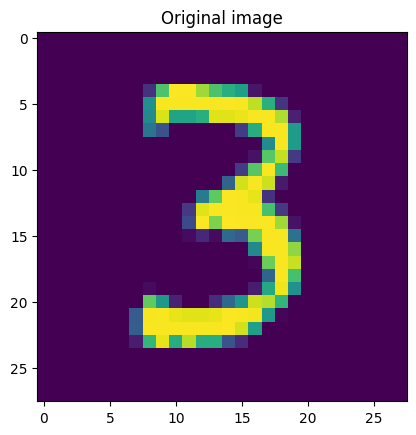

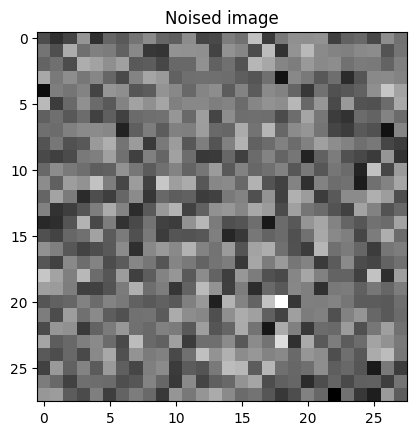

sampling loop time step: 100%|██████████| 300/300 [00:05<00:00, 56.55it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


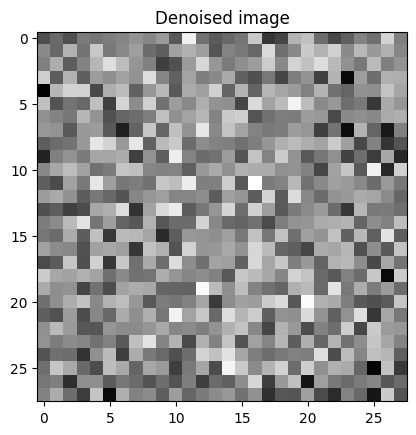

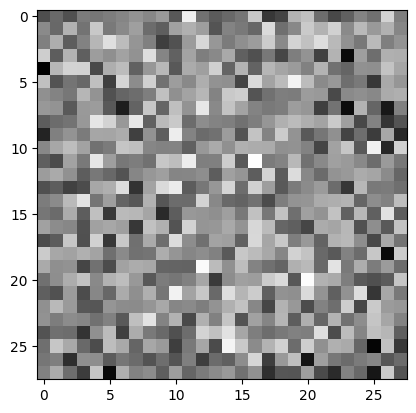

Image label: 9


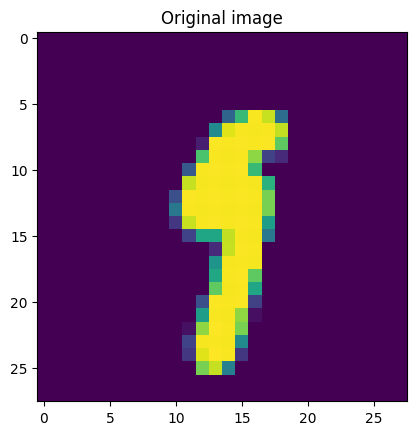

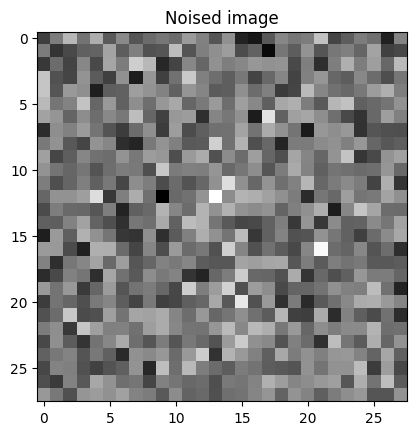

sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 61.24it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


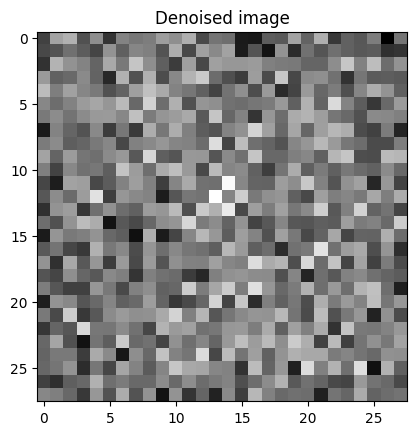

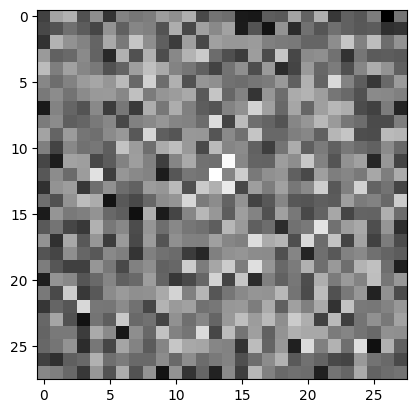

Image label: 8


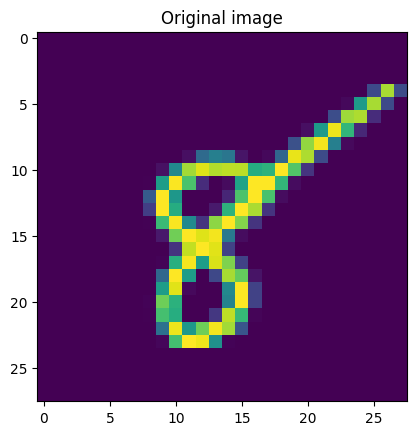

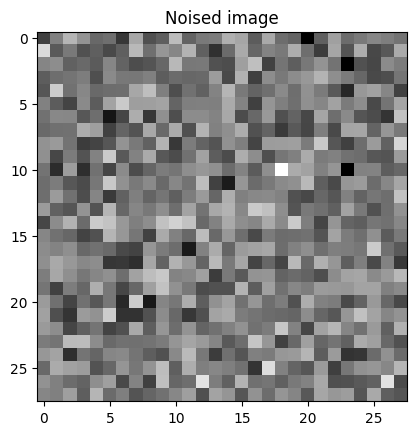

sampling loop time step: 100%|██████████| 300/300 [00:05<00:00, 55.78it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


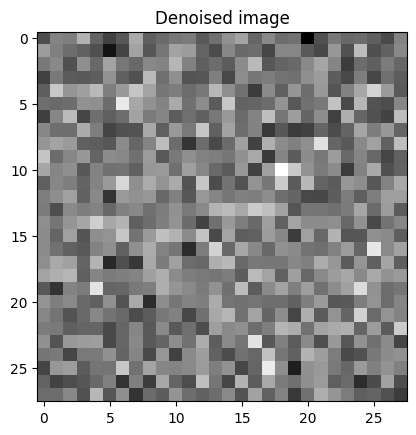

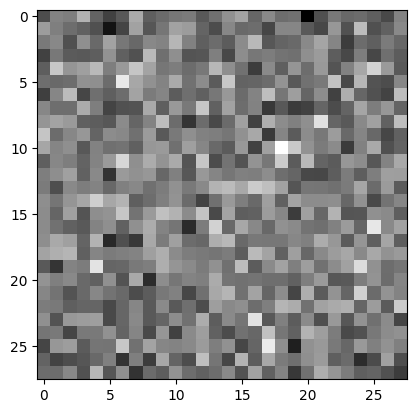

Image label: 1


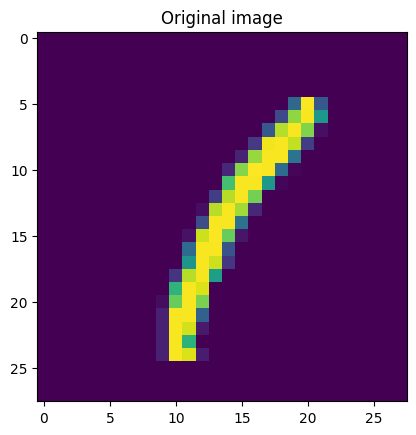

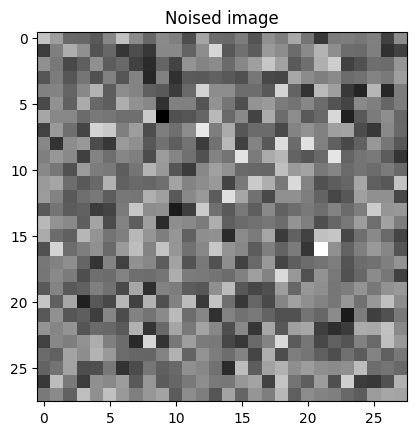

sampling loop time step: 100%|██████████| 300/300 [00:05<00:00, 56.36it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


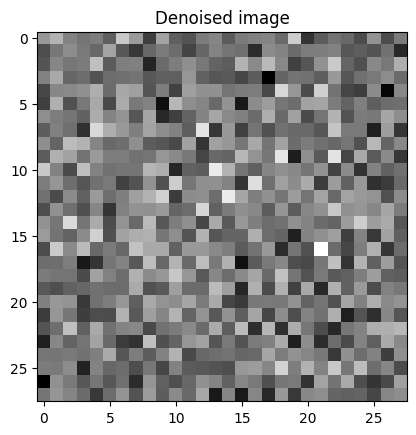

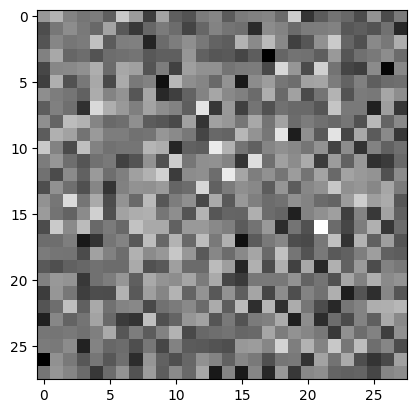

Image label: 5


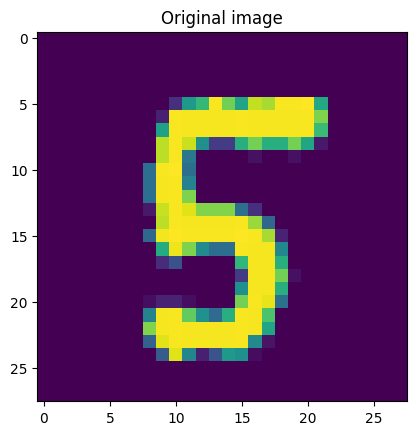

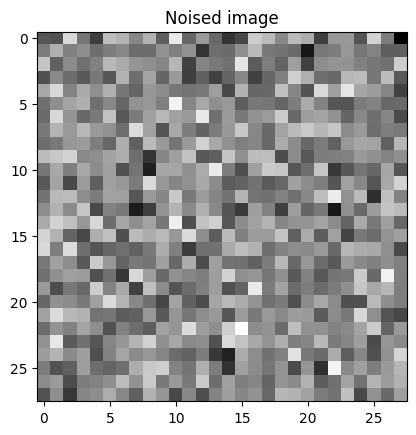

sampling loop time step: 100%|██████████| 300/300 [00:05<00:00, 55.93it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


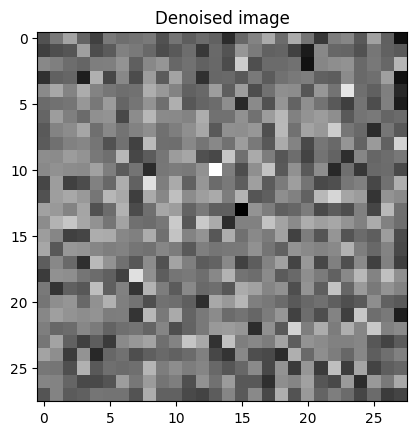

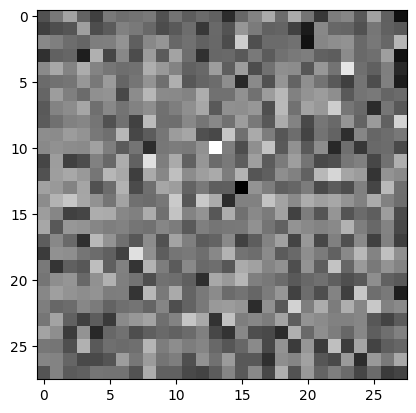

Image label: 3


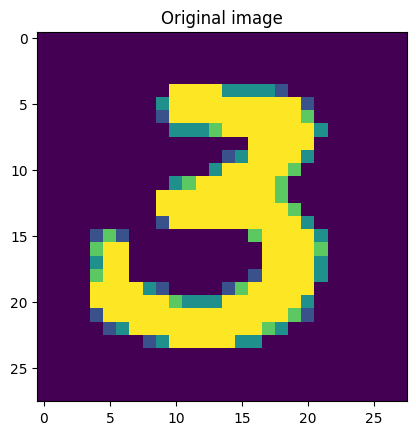

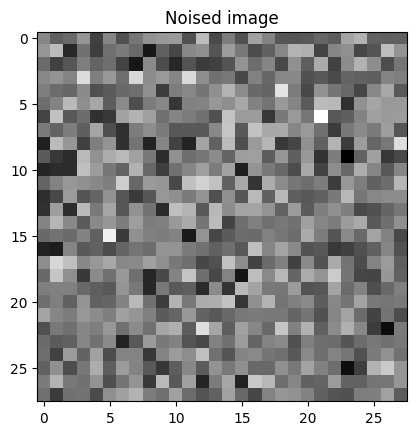

sampling loop time step: 100%|██████████| 300/300 [00:05<00:00, 56.44it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


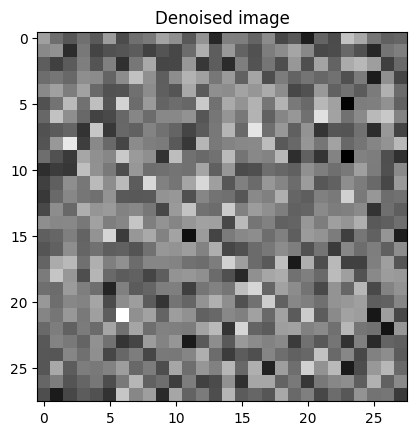

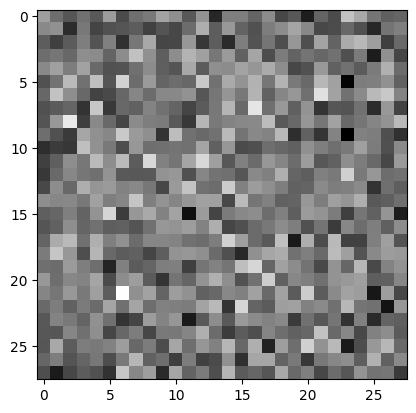

Image label: 9


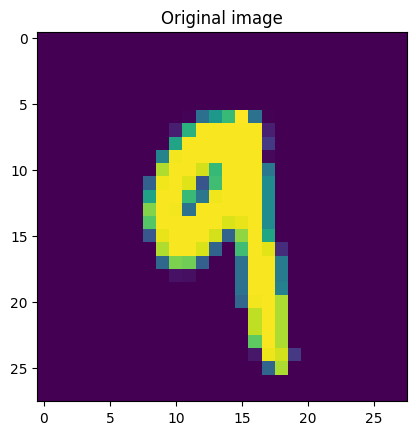

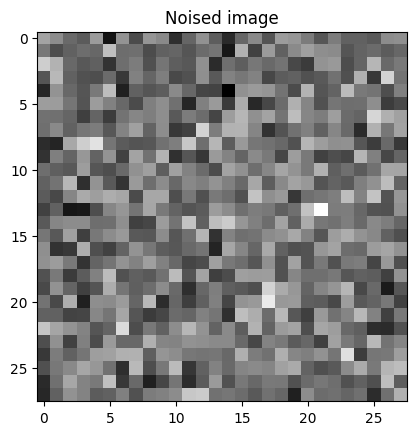

sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 60.90it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


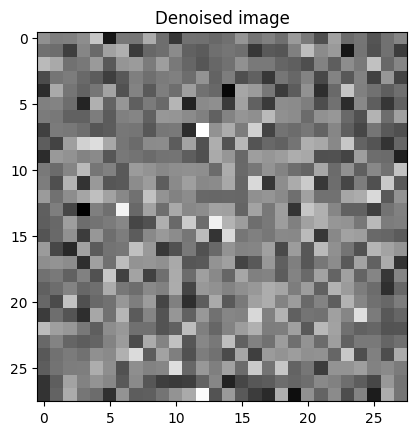

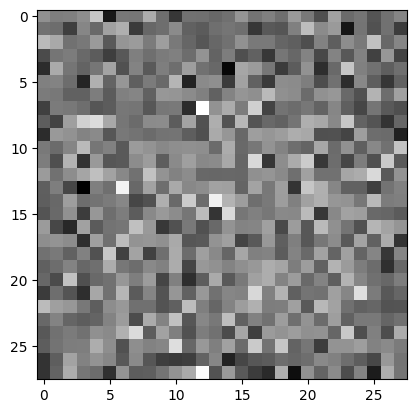

Image label: 8


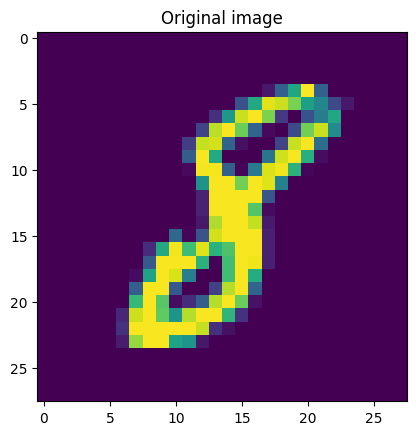

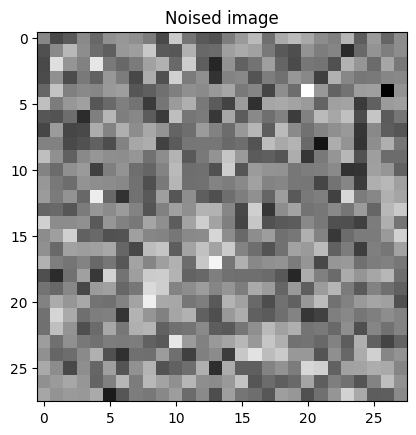

sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 60.75it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


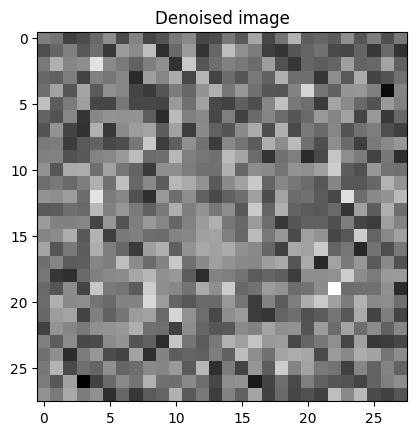

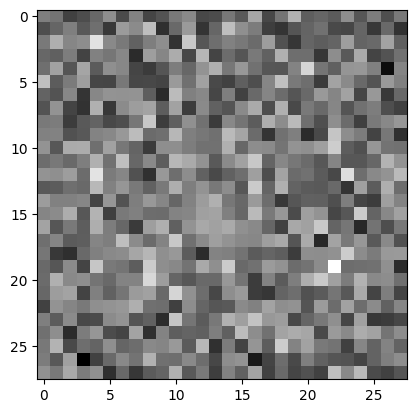

Image label: 9


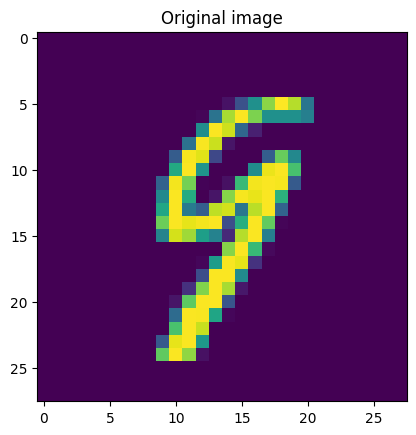

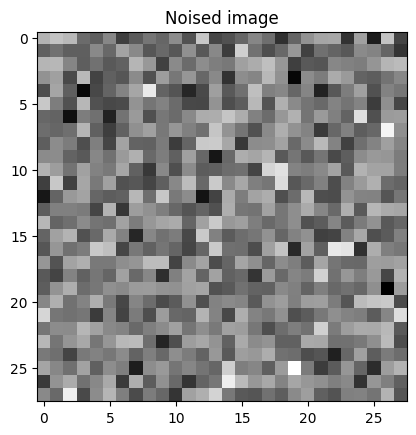

sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 61.65it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


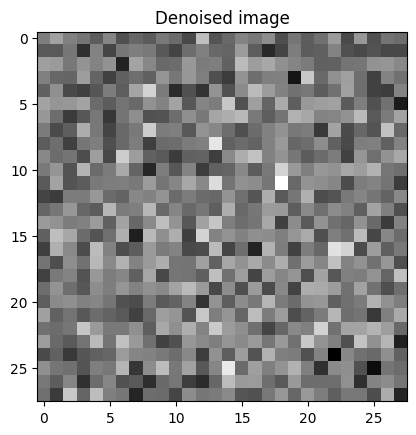

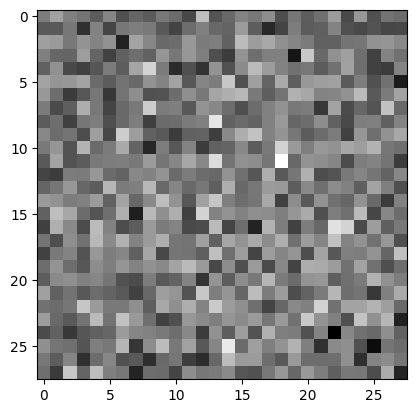

Image label: 9


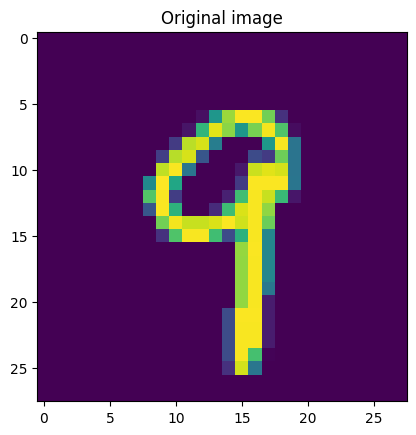

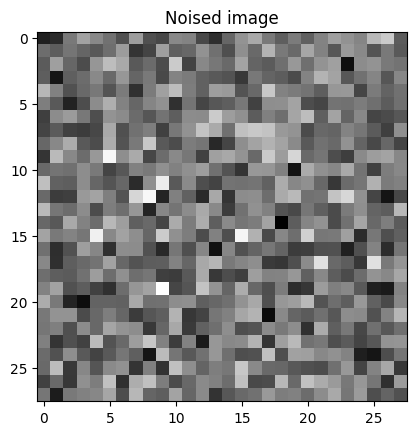

sampling loop time step: 100%|██████████| 300/300 [00:05<00:00, 56.81it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


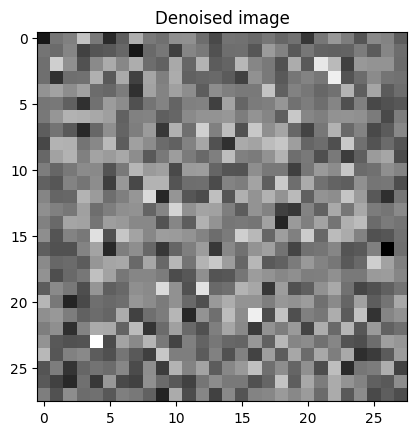

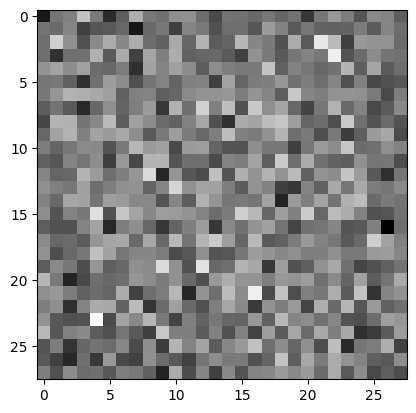

In [23]:
random_idxs = np.random.randint(0, len(dataset['train']), 10)
for idx in random_idxs:
    test_and_gif(int(idx))
    